In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

df = train.copy()

# Exploratory Data Analysis

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- A first look at the dataset shows us that some columns seem to be useless such as :
    - PassengerId
    - Name
    - Ticket

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.shape

(891, 12)

## Missing Values

In [8]:
df.isna().mean(axis=0).sort_values(ascending=False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

- We can see that the Cabin feature contains a lot of missing values (77%), it would make sense to drop it since using imputation on it will probably lead the model to perform poorly since it will use data that is technically incorrect.
- Column Age contains approximately 20% missing values, imputing it later on with the mean strategy seems to be the best plan.
- Column Embarked almost has no missing values

## Correlation Heatmap

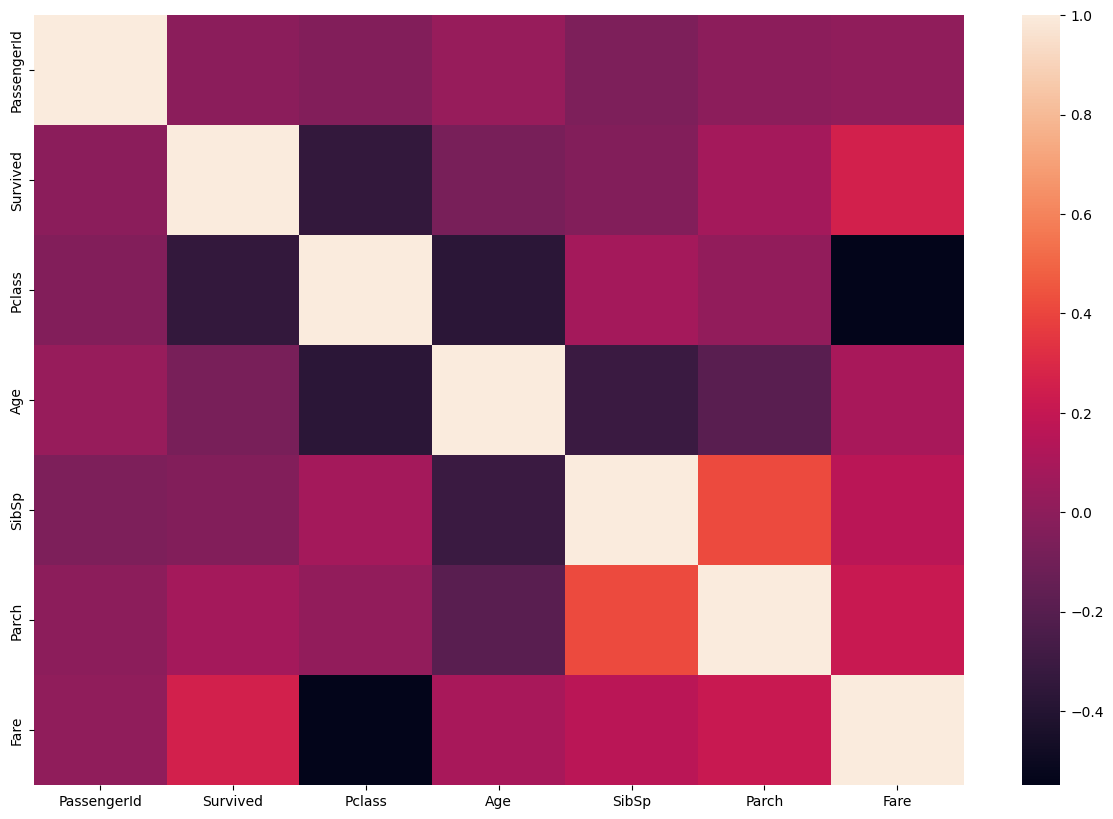

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=False)
plt.show()

- The code below will show us the most correlated features

In [10]:
correlation_matrix = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

most_correlated_pairs = (correlation_matrix.where(mask)
                         .stack()
                         .reset_index()
                         .rename(columns={0: 'Correlation'})
                         .sort_values(by='Correlation', ascending=False))

num_most_correlated = 10
for i, (feature1, feature2, correlation) in enumerate(most_correlated_pairs.head(num_most_correlated).itertuples(index=False), 1):
    print(f"{i}. {feature1} - {feature2}: {correlation:.2f}")


1. SibSp - Parch: 0.41
2. Survived - Fare: 0.26
3. Parch - Fare: 0.22
4. SibSp - Fare: 0.16
5. Age - Fare: 0.10
6. Pclass - SibSp: 0.08
7. Survived - Parch: 0.08
8. PassengerId - Age: 0.04
9. Pclass - Parch: 0.02
10. PassengerId - Fare: 0.01


- The most correlated features are SibSp - Parch with a correlation of 0.41. It is not high enough to consider new strategies such as dropping one of them or creating a new features that combines both of them, so we will leave it as it is for now

## Target Feature Distribution

In [11]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

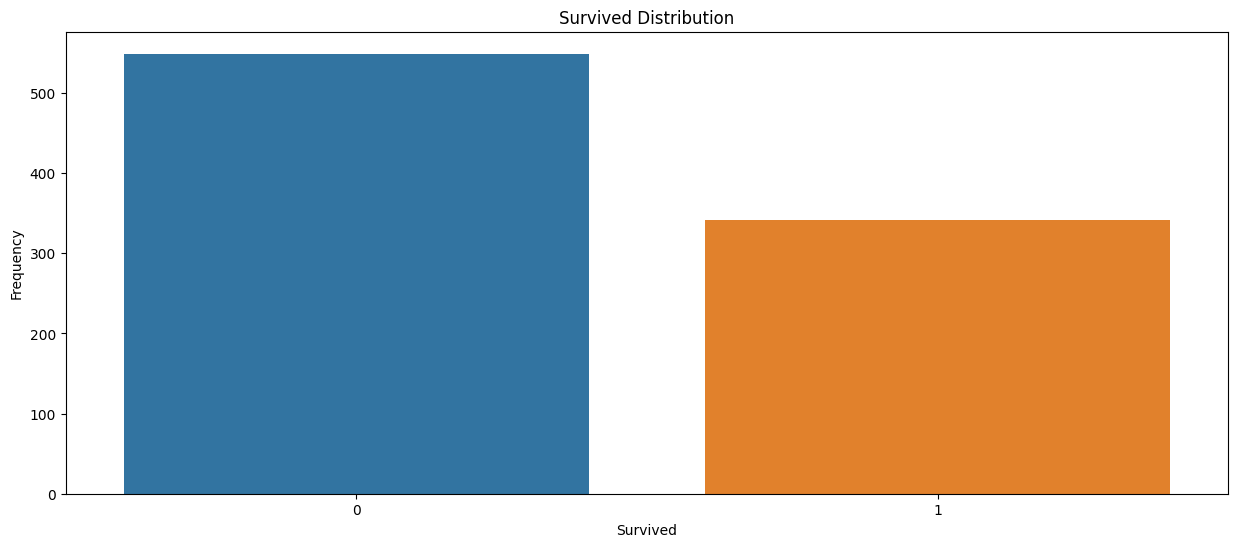

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x=df['Survived'])
plt.title('Survived Distribution')
plt.xlabel('Survived')
plt.ylabel('Frequency')
plt.show()

## Numerical Features Distribution

In [16]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('PassengerId')
# We removed the PassengerId column since it won't add anything, it is useless so we can safely dispose of it
numerical_features.remove('Survived')
# We also removed the Survived column which is our target since we already inspected it
numerical_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

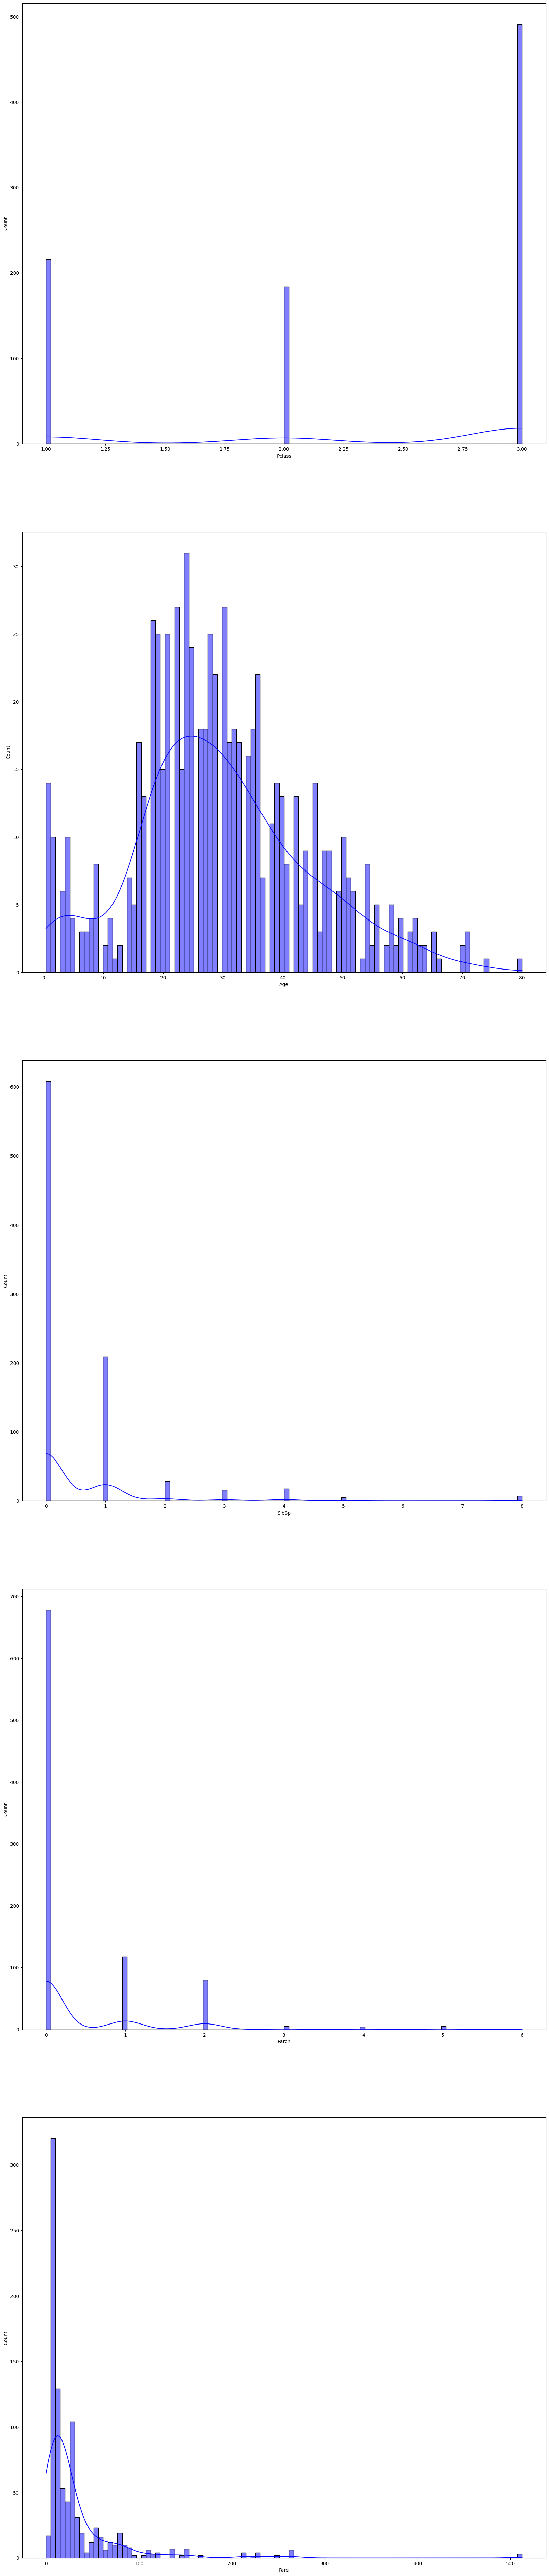

In [17]:
fig, ax = plt.subplots(len(numerical_features),1,  figsize=(20, 40))
plt.subplots_adjust(top = 2)

for index,column in enumerate(numerical_features):
    sns.histplot(df[column], color='b', bins=100, ax=ax[index], kde=True);

- Some features like Pclass seem almost like an encoded categorical column, and apart from the age distribution, the rest seem to have a bad distribution like the Fare features which contains a heavy tail. Generally, a machine learning model prefers normalized data so you should consider later on normalizing them but it won't always improve your model. For the sake of simplicity we will leave them as they are

## Categorical Features distribution

In [18]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features.remove('Name')
categorical_features.remove('Ticket')
categorical_features.remove('Cabin')
# We removed these three features since at first glance, they don't seem to provide much informations.
categorical_features

['Sex', 'Embarked']

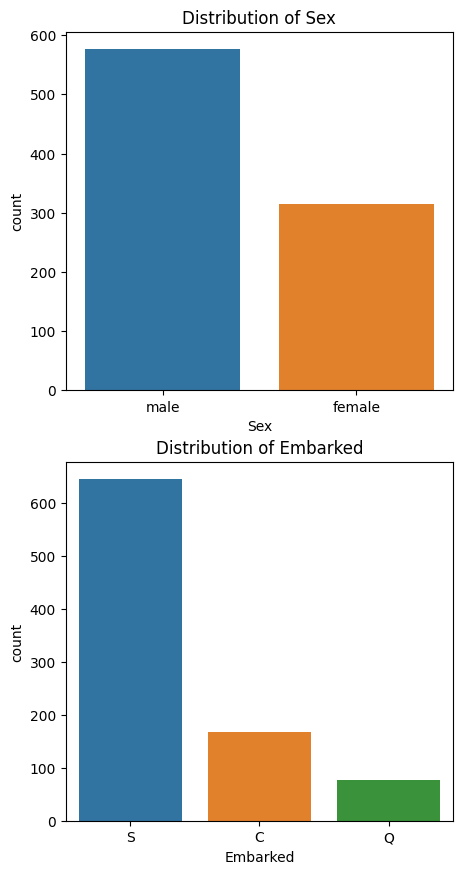

In [19]:
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(5, 1))
plt.subplots_adjust(top=8)

for index, column in enumerate(categorical_features):
    sns.countplot(data=df, x=column, ax=axes[index])
    axes[index].set_title(f'Distribution of {column}')

plt.show()

# Pre-Processing

In [20]:
def drop_features(df):
    return df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

The EDA showed us that we have categorical features that will need to be encoded, and also missing values which will need to be imputed. Some features also would better be dropped since they don't provide much informations. So our pre-processing phase will contain 3 main steps :
- Dropping useless columns
- Imputing the missing values 
- Encoding the categorical features

## Dropping some features

In [25]:
# We should apply the same pre-processing steps to both the train and test data
train = drop_features(train)
test = drop_features(test)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


## Imputation and Encoding

There are a lot of imputers and encoders available in scikit-learn, so I would recommend reading the documentation and experimenting with them

The first step is seperate the target and the features

In [29]:
X = train.drop(['Survived'], axis=1)
y = train.Survived

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

We will use a SimpleImputer with the most_frequent strategy for the sake of simplicity, feel free to try other strategies and other imputers.
The same goes with the encoding part, we will use OneHotEncoder but you can try using OrdinalEncoder for example. There are also encoders for binary features like LabelBinarizer but this one is used to encode the target and not features.
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [32]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

Both the concepts of pipeline and column transformers are explained here : 
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
To be brief, a column transformer will allow us to apply pre-processing steps like encoding or imputing on specific columns, while the pipeline will be applied to the entirety of the dataset

In [34]:
cols_to_encode = ['Sex', 'Embarked']

In [40]:
preprocessor = make_column_transformer(
    (SimpleImputer(strategy='mean'), ['Age']), 
    (make_pipeline(                                    
        SimpleImputer(strategy='most_frequent'),     
        OneHotEncoder(drop='if_binary', handle_unknown='ignore')  
    ), ['Embarked']),                                
    (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), ['Sex']),
    remainder='passthrough'
)

Above, we used a column transformer for our preprocessor :
- First step is imputing the column Age with SimpleImputer using the mean strategy since it is numerical
- The embarked column is both categorical and contains missing values, so instead of doing these steps seperately which will lead to problems such as encoding the nan values, we use a pipeline to combine the simple imputer and the encoder, and apply it to the Embraked column. Basically thanks to the pipeline, we were able to combine the imputation and encoding for the column Embarked
- We used a OneHotEncoder for the column Sex.

When drop='if_binary', OneHotEncoder will automatically drop one of the binary columns after encoding if the original feature is binary. This is done to avoid multicollinearity, which occurs when one feature can be perfectly predicted from one or more other features.
- remainder='passthrough' means that the rest of the columns will not be touched, they will be ignored by the preprocessor.

In [41]:
X_transformed = preprocessor.fit_transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
X_transformed_df

,simpleimputer__Age,pipeline__Embarked_C,pipeline__Embarked_Q,pipeline__Embarked_S,onehotencoder__Sex_male,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,22.000000,0.0,0.0,1.0,1.0,3.0,1.0,0.0,7.2500
1,38.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,71.2833
2,26.000000,0.0,0.0,1.0,0.0,3.0,0.0,0.0,7.9250
3,35.000000,0.0,0.0,1.0,0.0,1.0,1.0,0.0,53.1000
4,35.000000,0.0,0.0,1.0,1.0,3.0,0.0,0.0,8.0500
...,...,...,...,...,...,...,...,...,...
886,27.000000,0.0,0.0,1.0,1.0,2.0,0.0,0.0,13.0000
887,19.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,30.0000
888,29.699118,0.0,0.0,1.0,0.0,3.0,1.0,2.0,23.4500
889,26.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,30.0000


We used fit_transform on our train data and derived a pd DataFrame from it so we can see the result of the pre-processing

In [42]:
test_transformed = preprocessor.transform(test)
test_transformed_df = pd.DataFrame(test_transformed, columns=preprocessor.get_feature_names_out())
test_transformed_df

,simpleimputer__Age,pipeline__Embarked_C,pipeline__Embarked_Q,pipeline__Embarked_S,onehotencoder__Sex_male,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,34.500000,0.0,1.0,0.0,1.0,3.0,0.0,0.0,7.8292
1,47.000000,0.0,0.0,1.0,0.0,3.0,1.0,0.0,7.0000
2,62.000000,0.0,1.0,0.0,1.0,2.0,0.0,0.0,9.6875
3,27.000000,0.0,0.0,1.0,1.0,3.0,0.0,0.0,8.6625
4,22.000000,0.0,0.0,1.0,0.0,3.0,1.0,1.0,12.2875
...,...,...,...,...,...,...,...,...,...
413,29.699118,0.0,0.0,1.0,1.0,3.0,0.0,0.0,8.0500
414,39.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,108.9000
415,38.500000,0.0,0.0,1.0,1.0,3.0,0.0,0.0,7.2500
416,29.699118,0.0,0.0,1.0,1.0,3.0,0.0,0.0,8.0500


The same is done to the test set, the same transformations applied on the train are applied on the test with using transform only on the test instead of fit_transform like in the train

We will now split our train data into train and validation in order to see how our model performs

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_transformed_df, y, test_size=0.2)

We will now import some models, feel free to change the model and see the result for yourself, here we went with a random forest model but i will import other models so you can try them.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [48]:
model = RandomForestClassifier(random_state=42)

In [49]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

The metric from the competition is accuracy, so will import it 

In [51]:
from sklearn.metrics import accuracy_score

In [53]:
preds = model.predict(X_val)
accuracy = accuracy_score(preds, y_val)

In [54]:
accuracy

0.8268156424581006

Our RandomForest model scored and 82% accuracy, let's try another model, XGBClassifier for example

In [55]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)
accuracy = accuracy_score(preds, y_val)
accuracy

0.8212290502793296

Feel free to try other models

### Final prediction
Here we will train our model on the entire train set and predict on the test set

In [56]:
model.fit(X_transformed_df, y)
y_pred = model.predict(test_transformed_df)
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

And now we will save a csv file to submit to kaggle.

In [57]:
submission["Survived"] = y_pred
submission.to_csv("submission.csv", index=False)

# General remarks :
- When the dataset doesn't contain much data like this one for example, using train_test_split is generally a bad strategy, since we will not train our model on the entire data. Training the model on few examples means it will probably not generalize. 
- The alternative and general better approach is using cross validation.
- Common problems that can occur to you are overfitting and underfitting so read about them